In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [2]:
# --- 1. Load the Dataset ---
# Define the path to your dataset file
DATASET_PATH = 'Bank Customer Churn Prediction.csv'
df = pd.read_csv(DATASET_PATH)
print(f"Dataset '{DATASET_PATH}' loaded successfully.")
print(f"Initial dataset shape: {df.shape} (rows, columns)")
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nDataset Information:")
df.info()
print("\nMissing values before preprocessing:")
print(df.isnull().sum())

Dataset 'Bank Customer Churn Prediction.csv' loaded successfully.
Initial dataset shape: (10000, 12) (rows, columns)

First 5 rows of the dataset:
   customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1    

In [3]:
#drop customer_id as we dont need it in the predictions
df.drop('customer_id', axis =1)
df.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

/usr/local/anaconda/envs/tensorflow2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


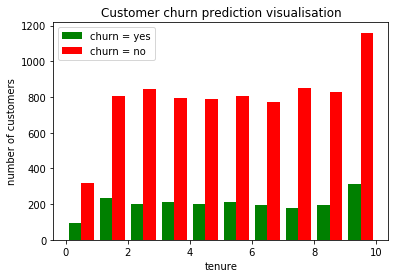

In [4]:
# lets plot the customer churn data yes or no depending on the tenure 
tenure_churn_no = df[df.churn == 0].tenure
tenure_churn_yes = df[df.churn ==1].tenure

plt.xlabel("tenure")
plt.ylabel("number of customers")
plt.title("Customer churn prediction visualisation")
plt.hist([ tenure_churn_yes, tenure_churn_no], color= ['green', 'red'], label= ['churn = yes', 'churn = no'])
plt.legend()

In [5]:
if 'customer_id' in df.columns:
    df = df.drop('customer_id', axis=1)
    print("\n'Customer ID' column dropped as it's not relevant for prediction.")
    print(f"Dataset shape after dropping Customer ID : {df.shape}")


TARGET_COLUMN = 'churn'

print(f"Encoded target variable distribution:\n{df[TARGET_COLUMN].value_counts()}")

# Separate features (X) and target (y)
X = df.drop(TARGET_COLUMN, axis=1)
y = df[TARGET_COLUMN]



'Customer ID' column dropped as it's not relevant for prediction.
Dataset shape after dropping Customer ID : (10000, 11)
Encoded target variable distribution:
0    7963
1    2037
Name: churn, dtype: int64


In [6]:
# Identify numerical and categorical features for preprocessing
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nIdentified numerical features: {numerical_features}")
print(f"Identified categorical features: {categorical_features}")

# Handle missing values:
# For numerical features, we'll impute with the median.
# For categorical features, we'll impute with the most frequent value (mode).
for col in numerical_features:
    if X[col].isnull().any():
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        print(f"Filled missing values in numerical column '{col}' with median: {median_val}")

for col in categorical_features:
    if X[col].isnull().any():
        mode_val = X[col].mode()[0]       
        X[col] = X[col].fillna(mode_val)
        print(f"Filled missing values in categorical column '{col}' with mode: {mode_val}")

print(f"\nTotal missing values after imputation: {X.isnull().sum().sum()} (should be 0)")



Identified numerical features: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']
Identified categorical features: ['country', 'gender']

Total missing values after imputation: 0 (should be 0)


In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any) that are not specified
)

In [8]:
# Apply the preprocessing to the features
X_processed = preprocessor.fit_transform(X)

# Get the number of features after preprocessing. This will be the input shape for our Keras model.
num_features_after_preprocessing = X_processed.shape[1]
print(f"\nNumber of features after preprocessing (input to the model): {num_features_after_preprocessing}")

# Split the preprocessed data into training and testing sets.
# test_size=0.2 means 20% of the data will be used for testing, 80% for training.
# random_state=42 ensures reproducibility of the split.
# stratify=y ensures that the proportion of target classes (0s and 1s) is maintained in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nShape of training features (X_train): {X_train.shape}")
print(f"Shape of training target (y_train): {y_train.shape}")
print(f"Shape of testing features (X_test): {X_test.shape}")
print(f"Shape of testing target (y_test): {y_test.shape}")




Number of features after preprocessing (input to the model): 13

Shape of training features (X_train): (8000, 13)
Shape of training target (y_train): (8000,)
Shape of testing features (X_test): (2000, 13)
Shape of testing target (y_test): (2000,)


In [9]:
# --- 3. Build the Keras Model Architecture (using TensorFlow backend) ---
# We will create a Sequential model, which is a linear stack of layers.

model = keras.Sequential([
    # First Hidden Layer:
    # - 300 neurons
    # - 'relu' (Rectified Linear Unit) activation function: f(x) = max(0, x).
    #   It introduces non-linearity, allowing the model to learn complex patterns.
    # - input_shape: Specifies the shape of the input data. This is crucial for the first layer.
    keras.layers.Dense(100, activation='relu', input_shape=(num_features_after_preprocessing,), name='hidden_layer_1'),

    # Second Hidden Layer:
    # - 100 neurons
    # - 'relu' activation function.
    keras.layers.Dense(64, activation='relu', name='hidden_layer_2'),

    # Output Layer:
    # - 1 neuron: For binary classification (cancer or no cancer), a single output neuron is sufficient.
    # - 'sigmoid' activation function: squashes the output to a value between 0 and 1,
    #   representing the probability of the positive class (Malignant/Cancer).
    keras.layers.Dense(1, activation='sigmoid', name='output_layer')
])

# Display the model summary. This shows the layers, output shape, and number of parameters.
print("\n--- Keras Model Summary ---")
model.summary()


--- Keras Model Summary ---
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 100)               1400      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                6464      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 7,929
Trainable params: 7,929
Non-trainable params: 0
_________________________________________________________________


In [10]:
# --- 4. Compile the Model ---
# Compiling configures the model for training.

model.compile(
    optimizer='adam',  # Optimizer: Adam is an efficient stochastic gradient descent optimizer.
                       # It adapts the learning rate during training, often leading to faster convergence.
    loss='binary_crossentropy', # Loss function: Binary Crossentropy is suitable for binary classification
                                # problems where the output is a probability (from sigmoid activation).
                                # It measures the difference between predicted probabilities and actual binary labels.
    metrics=['accuracy'] # Metrics: 'accuracy' will be monitored during training and evaluation.
                         # It represents the proportion of correctly classified samples.
)
print("\nModel compiled successfully with Adam optimizer, Binary Crossentropy loss, and Accuracy metric.")


Model compiled successfully with Adam optimizer, Binary Crossentropy loss, and Accuracy metric.


In [11]:
# --- 5. Train the Model ---
# Train the model using the training data.

EPOCHS = 100     # Number of times the model will iterate over the entire training dataset.
                 # You can experiment with this value. More epochs can lead to better learning,
                 # but also to overfitting.
BATCH_SIZE = 32  # Number of samples per gradient update. Training is done in mini-batches.
                 # Smaller batch sizes can lead to more noisy updates but potentially better generalization.
                 # Larger batch sizes can speed up training but might get stuck in local minima.

print(f"\n--- Training the Model ---")
print(f"Training for {EPOCHS} epochs with a batch size of {BATCH_SIZE}.")
print(f"Using 10% of training data for validation during training.")



--- Training the Model ---
Training for 100 epochs with a batch size of 32.
Using 10% of training data for validation during training.


In [12]:
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1, # Reserve 10% of the training data for validation.
                          # This helps monitor performance on unseen data during training and detect overfitting.
    verbose=1             # Show progress bar during training. Set to 0 for silent, 2 for one line per epoch.
)
print("\nModel training complete.")

Epoch 1/100
225/225 [==============================] - 1s 3ms/step - loss: 0.4211 - accuracy: 0.8238 - val_loss: 0.3651 - val_accuracy: 0.8438
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 0.3615 - accuracy: 0.8521 - val_loss: 0.3260 - val_accuracy: 0.8675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 0.3491 - accuracy: 0.8571 - val_loss: 0.3121 - val_accuracy: 0.8763
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 0.3440 - accuracy: 0.8575 - val_loss: 0.3141 - val_accuracy: 0.8675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 0.3416 - accuracy: 0.8567 - val_loss: 0.3172 - val_accuracy: 0.8725
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 0.3362 - accuracy: 0.8608 - val_loss: 0.3236 - val_accuracy: 0.8625
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.3327 - accuracy: 0.8657 - val_loss: 0.3101 - val_accuracy: 0.8675

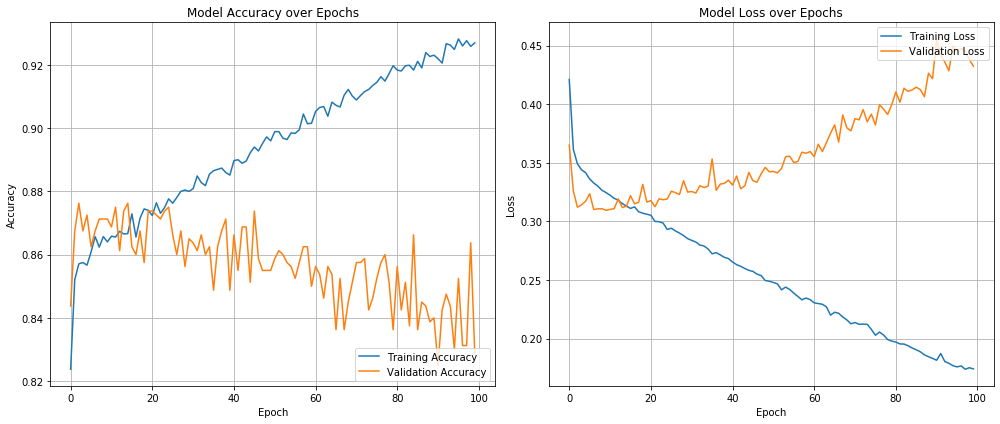


Training history plots displayed (Accuracy and Loss).


In [13]:
# --- 7. Visualize Training History ---
# Plot the training and validation accuracy and loss over epochs.
# This helps to understand if the model is learning well, overfitting, or underfitting.

plt.figure(figsize=(14, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()
print("\nTraining history plots displayed (Accuracy and Loss).")

In [ ]:
# --- 8. Make Predictions (Optional) ---
# Demonstrate how to use the trained model to make predictions on new, unseen data.

print("\n--- Making Predictions ---")
# Let's predict on the first 10 samples from the test set
num_predictions_to_show = 10
sample_X_test = X_test[:num_predictions_to_show]
sample_y_test = y_test.head(num_predictions_to_show).values # Get corresponding true labels
sample_y_test

In [18]:
# Predict probabilities
predictions_proba = model.predict(X_test)

# Predict probabilities
predictions_proba = model.predict(X_test)

# Convert probabilities to binary class labels (0 or 1) based on a threshold (e.g., 0.5)
predictions_classes = (predictions_proba > 0.5).astype(int).flatten()

print(f"\nPredictions for the first {num_predictions_to_show} test samples:")
for i in range(num_predictions_to_show):
    true_label_text = [sample_y_test[i]][0]
   # print(true_label_text)
    predicted_label_text =[predictions_classes[i]][0]
    print(f"Sample {i+1}: True Label: {true_label_text} ({sample_y_test[i]}), "
          f"Predicted Probability: {predictions_proba[i][0]:.4f}, "
          f"predicted Class: {predicted_label_text} ({predictions_classes[i]})")
    


Predictions for the first 10 test samples:
Sample 1: True Label: 0 (0), Predicted Probability: 0.0436, predicted Class: 0 (0)
Sample 2: True Label: 0 (0), Predicted Probability: 0.0085, predicted Class: 0 (0)
Sample 3: True Label: 0 (0), Predicted Probability: 0.0023, predicted Class: 0 (0)
Sample 4: True Label: 0 (0), Predicted Probability: 0.0045, predicted Class: 0 (0)
Sample 5: True Label: 0 (0), Predicted Probability: 0.0453, predicted Class: 0 (0)
Sample 6: True Label: 0 (0), Predicted Probability: 0.0113, predicted Class: 0 (0)
Sample 7: True Label: 0 (0), Predicted Probability: 0.0196, predicted Class: 0 (0)
Sample 8: True Label: 0 (0), Predicted Probability: 0.3644, predicted Class: 0 (0)
Sample 9: True Label: 0 (0), Predicted Probability: 0.9994, predicted Class: 1 (1)
Sample 10: True Label: 0 (0), Predicted Probability: 0.0421, predicted Class: 0 (0)
